In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from src.model import EDSR
from src.dataset import CustomImageDataset
from src.config import val_hr_data_path, val_lr_data_path

In [ ]:
model_path = "./checkpoints/best_model.pth"
model = EDSR(scale_factor=2, num_channels=3, num_features=64, num_blocks=16)
model.to(device)

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Модель загружена из {model_path}")
else:
    raise FileNotFoundError(f"Модель не найдена: {model_path}")

In [ ]:
scale_factor = 2
patch_size_lr = 128
batch_size = 8

val_dataset = CustomImageDataset(
        hr_dir=val_hr_data_path,
        lr_dir=val_lr_data_path,
        scale_factor=scale_factor,
        patch_size=patch_size_lr
    )
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
def tensor_to_numpy(tensor):
    """Преобразует тензор (C, H, W) -> (H, W, C) для отображения."""
    tensor = tensor.cpu().detach().numpy()
    return tensor.transpose(1, 2, 0)

def calculate_psnr(img1, img2, max_val=1.0):
    mse = torch.mean((img1 - img2) ** 2)
    if mse.item() == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse))

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Модель загружена из {model_path}")
else:
    raise FileNotFoundError(f"Модель не найдена по пути: {model_path}")

Модель загружена из /kaggle/working/final_model.pth


In [ ]:
# Визуализация одного примера: выводим предсказание модели для первого изображения из батча
model.eval()

data_iter = iter(val_loader)
lr_batch, hr_batch = next(data_iter)

lr_img = lr_batch[[0]].to(device)
hr_img = hr_batch[0].cpu()

with torch.no_grad():
    sr_img = model(lr_img)
sr_img_np = tensor_to_numpy(sr_img[0])
lr_img_np = tensor_to_numpy(lr_img[0].cpu())
hr_img_np = tensor_to_numpy(hr_img)

sr_img_np = np.clip(sr_img_np, 0, 1)
lr_img_np = np.clip(lr_img_np, 0, 1)
hr_img_np = np.clip(hr_img_np, 0, 1)

psnr_sr_hr = calculate_psnr(sr_img[0].cpu(), hr_batch[0], max_val=1.0)

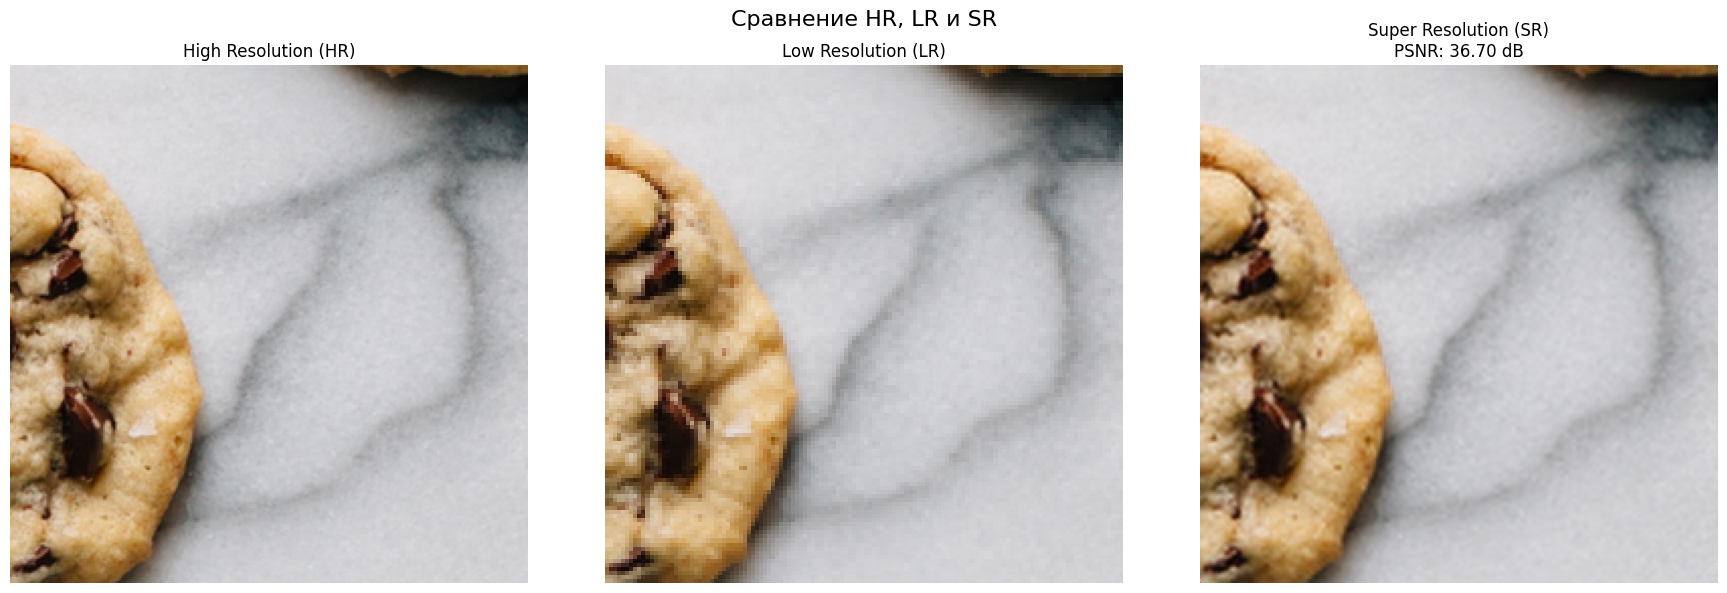

In [39]:
# Визуализация
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title(f"High Resolution (HR)")
plt.imshow(hr_img_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title(f"Low Resolution (LR)")
plt.imshow(lr_img_np)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Super Resolution (SR)\nPSNR: {psnr_sr_hr:.2f} dB")
plt.imshow(sr_img_np)
plt.axis("off")

plt.suptitle("Сравнение HR, LR и SR", fontsize=16)
plt.tight_layout()
plt.show()